In [316]:
%pip install pandas
%pip install scikit-learn
%pip install torch

10725.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


10730.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


10736.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [317]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import PchipInterpolator
from sklearn.preprocessing import StandardScaler, RobustScaler


In [318]:
grandom_state = 69

hq_train_data_path = "./Data/hq_markup_train.csv"
lq_train_data_path = "./Data/markup_train.csv"

In [319]:
hq_train_data = pd.read_csv(hq_train_data_path).sample(frac=1, random_state = grandom_state)
lq_train_data = pd.read_csv(lq_train_data_path).sample(frac=1,random_state = grandom_state)


In [320]:
bin_features = [
    "Некачественное ГДИС",
    "Влияние ствола скважины",
    "Радиальный режим",
    "Линейный режим",
    "Билинейный режим",
    "Сферический режим",
    "Граница постоянного давления",
    "Граница непроницаемый разлом",
]
value_features = [f + "_details" for f in bin_features[1:]]
hq_train_data

,file_name,department_name,user_name,Некачественное ГДИС,Влияние ствола скважины,Радиальный режим,Линейный режим,Билинейный режим,Сферический режим,Граница постоянного давления,Граница непроницаемый разлом,Влияние ствола скважины_details,Радиальный режим_details,Линейный режим_details,Билинейный режим_details,Сферический режим_details,Граница постоянного давления_details,Граница непроницаемый разлом_details
481,b69a5224-b023-4348-ae94-7f85263b97d1,department2,user4,0,1,1,0,1,0,0,0,1.969838,0.714405,NaN,0.331904,NaN,NaN,NaN
130,1b742ac4-ab8b-4eba-b465-8398b3678d8f,department3,user2,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,cf0447bd-d3bd-4563-ab53-6a6eb706d5e9,department2,user4,0,1,1,0,0,1,0,0,2.642711,0.587055,NaN,NaN,1.334979,NaN,NaN
162,4d4e1792-ff33-476e-bfee-624cf7ba1bc8,department3,user4,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,e9c7e07f-b723-4da3-918e-7dbcb360c830,department2,user5,0,1,1,0,0,0,0,1,2.082030,0.109087,NaN,NaN,NaN,NaN,4.647373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,e4eb77cf-e20b-4b83-ad73-500399fd2b8d,department2,user14,0,1,1,0,1,0,0,1,1.801439,0.888582,NaN,0.263107,NaN,NaN,661.478022
107,1eaadbd3-6a7b-4d53-888c-f0bf6502a888,department3,user4,0,1,0,0,0,1,1,0,1.845751,NaN,NaN,NaN,1.342652,20.901839,NaN
457,50a011e9-2a71-4804-b2f4-fba8abb9917f,department2,user5,0,1,1,0,0,0,0,1,2.799587,0.440943,NaN,NaN,NaN,NaN,6.484677
203,7b6b0387-68ef-4009-9775-01a93db0339d,department4,user12,0,1,1,0,0,1,1,0,2.164811,-0.864398,NaN,NaN,-0.639542,121.304209,NaN


<Axes: >

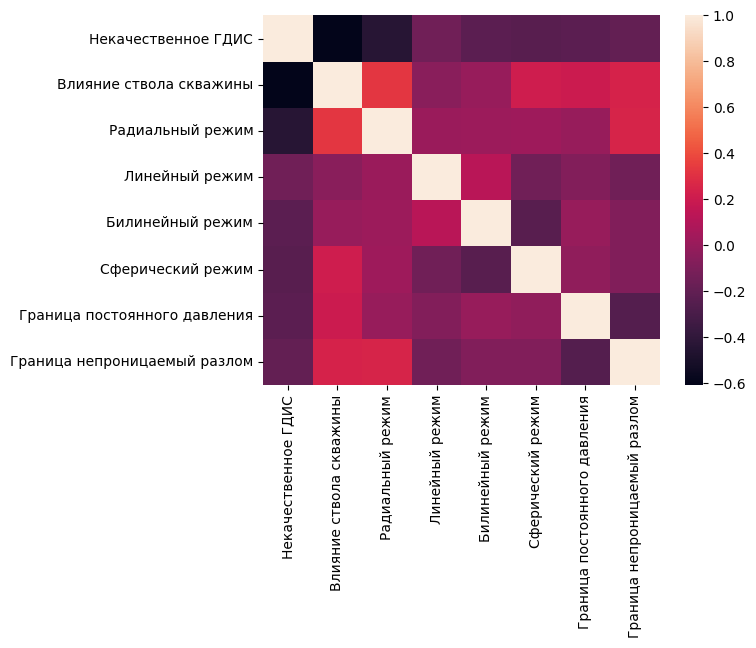

In [321]:
bin_corr = hq_train_data[bin_features].corr()
sns.heatmap(
    bin_corr, xticklabels=bin_corr.columns.values, yticklabels=bin_corr.columns.values
)

<Axes: >

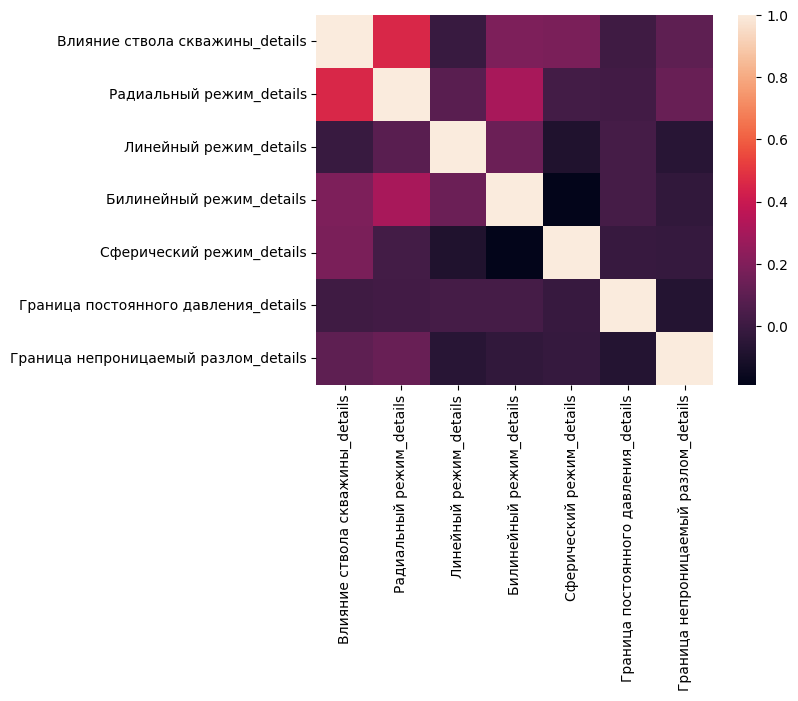

In [322]:
bin_corr = hq_train_data[value_features].fillna(-1).corr()
sns.heatmap(
    bin_corr, xticklabels=bin_corr.columns.values, yticklabels=bin_corr.columns.values
)

In [323]:
def get_series(file_name: str, train=True) -> pd.DataFrame | None:
    """
    Загружает данные из файла с указанным UUID в DataFrame

    Параметры:
    uuid (str): Идентификатор файла
    data_dir (str): Путь к папке с данными (по умолчанию 'data')

    Возвращает:
    pd.DataFrame: DataFrame с колонками ['Time', 'DeltaP', 'P_prime']
    или None если файл не найден
    """
    if train:
        file_path = os.path.join("Data/data", file_name)
    else:
        file_path = os.path.join("Data/validation 1", file_name)
    try:
        df = pd.read_csv(
            file_path,
            sep="\t",
            header=None,
            names=["Time", "DeltaP", "P_prime"],
            dtype={"Time": "float32", "DeltaP": "float32", "P_prime": "float32"},
            engine="c",
        )
        return df
    except FileNotFoundError as x:
        print(f"File not found in path:\t {file_path}\n" + x)
        return None


def get_series_from_loc(loc: pd.Series, train=True) -> pd.DataFrame | None:
    return get_series(loc["file_name"])


def show_series(s, ax) -> None:
    ax.loglog(s["Time"], s["DeltaP"], "o", markersize=3, color="b", label="Давление")
    ax.loglog(
        s["Time"],
        s["P_prime"],
        "s",
        markersize=3,
        color="g",
        label="Производная давления",
    )
    # ax.set_aspect("equal")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)


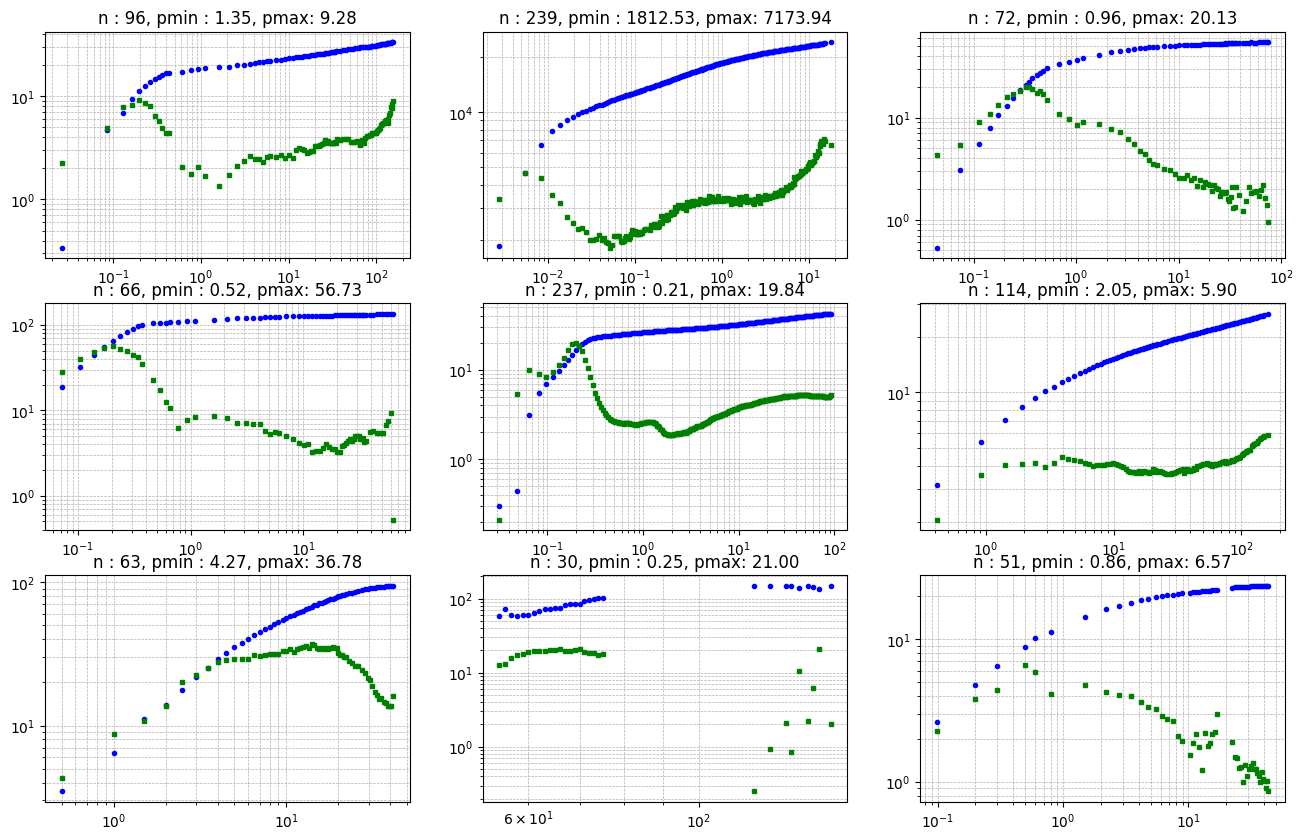

In [324]:
# show some series
size = (3, 3)
random_rows = hq_train_data.sample(n=size[1] * size[0], random_state=grandom_state)
fig, ax = plt.subplots(
    *size,
    figsize=(16, 10),
)
for i, v in enumerate(random_rows.iloc):
    x = ax[i // size[0], i % size[1]]
    s = get_series_from_loc(v)
    show_series(s, x)
    x.set_title(
        f"n : {len(s.index)}, pmin : {s['P_prime'].min():.2f}, pmax: {s['P_prime'].max():.2f}"
    )
    # show_series(get_series_from_loc(v), ax)


In [331]:
class OilDataset(Dataset):
    def __init__(self, hq_train_data, lq_train_data, get_data_fn=get_series_from_loc):
        super().__init__()
        self.hq_train_data= hq_train_data
        self.lq_train_data= lq_train_data
        self.get_data_fn = get_data_fn
        self.bin_features = [
            "Некачественное ГДИС",
            "Влияние ствола скважины",
            "Радиальный режим",
            "Линейный режим",
            "Билинейный режим",
            "Сферический режим",
            "Граница постоянного давления",
            "Граница непроницаемый разлом",
        ]
        self.value_features = [f + "_details" for f in bin_features[1:]]
        self.series_transform=  None
        self.data_transform= None
        self.hq = True
    def __len__(self):
        if self.hq:
            return len(self.hq_train_data.index)
        return len(self.lq_train_data.index)
    
    def _series_trainsform(self, s):
    # Интерполяция с сохранением временной оси
        time_original = s['Time'].values
        time_new = np.linspace(time_original.min(), time_original.max(), 512)
        
        # Нормализация времени
        time_scaled = (time_new - time_new.min()) / (time_new.max() - time_new.min() + 1e-8)
        
        # Интерполяция остальных каналов
        delta_p_interp = PchipInterpolator(time_original, s['DeltaP'])(time_new)
        p_prime_interp = PchipInterpolator(time_original, s['P_prime'])(time_new)
        
        # Нормализация данных
        data = np.vstack([
            time_scaled,
            StandardScaler().fit_transform(delta_p_interp.reshape(-1, 1)).flatten(),
            StandardScaler().fit_transform(p_prime_interp.reshape(-1, 1)).flatten()
        ])
        
        return torch.tensor(data, dtype=torch.float32)  # [3, 512]

    def _data_transform(self, loc):
            # Бинарные признаки
        bin_data = torch.tensor(loc[self.bin_features].values.astype(np.float32)) # [8]
        
        # Числовые детали с учетом порядка режимов
        details = loc[self.value_features].copy()
        
        # Замена NaN и масштабирование с сохранением порядка признаков
        details_filled = details.astype(np.float32).fillna(0).values
        details_scaled = RobustScaler().fit_transform(details_filled.reshape(-1, 1))  # [7]
        
        return (bin_data, torch.tensor(details_scaled, dtype=torch.float32))

    def transform(self, s, d):
        return self._series_trainsform(s), self._data_transform(d)

    def __getitem__(self, idx):
        if self.hq:
            loc = self.hq_train_data.iloc[idx]
            return self.transform(get_series_from_loc(loc), loc)
        else:
            loc = self.lq_train_data.iloc[idx]
            return self.transform(get_series_from_loc(loc), loc)
        

dataset = OilDataset(hq_train_data, lq_train_data)
dataset.hq = False
loader = DataLoader(dataset, batch_size=128)
print((dataset[0][0].size()))

torch.Size([3, 512])


In [332]:
class OilModel(nn.Module):
    def __init__(self, input_size=512, lstm_size=256, num_classes=7):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_size, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_size, 8),
            nn.Sigmoid()
        )
        self.regressor = nn.Sequential(
            nn.Linear(lstm_size, 7)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.mean(dim=1)  # Временное усреднение
        return self.classifier(out), self.regressor(out)

model = OilModel()

In [334]:
def train_epoch(model=model, loader=loader, optimizer=torch.optim.Adam(model.parameters()), device='cpu'):
    model.train()
    bin_loss = nn.BCELoss()
    reg_loss = nn.MSELoss()

    for X, (y_bin, y_reg) in loader:
        X, y_bin, y_reg = X.to(device), y_bin.to(device), y_reg.to(device)

        optimizer.zero_grad()
        pred_bin, pred_reg = model(X)
        y_reg = y_reg.squeeze(-1)

        # Комбинированный loss с маскированием
        loss_cls = bin_loss(pred_bin, y_bin)
        mask = (y_reg != -1).float()
        loss_reg = (reg_loss(pred_reg, y_reg) * mask).mean()

        total_loss = loss_cls + loss_reg
        print(loss_cls, loss_reg, total_loss)
        total_loss.backward()
        optimizer.step()

# train_epoch(loader = loader)
# dataset.hq = False
train_epoch()

# loader = DataLoader(dataset, batch_size=128)


ValueError: `x` must contain at least 2 elements.